## Resource-Constrained Project Scheduling with Blocking Times - Joint Calendars

### Problem Definiton

Tasks have flexible execution windows (preemption allowed based on availability) but strict finish-to-start precedence constraints. Each task requires specific quantities of resources from disjoint candidate sets. Unlike standard duration-based scheduling, tasks here are defined by size, allowing them to split across resource breaks (e.g., weekends) automatically. Formally, the problem is defined as follows: Let $\mathcal{N}=\{1,\ldots,N\}$ be a set of tasks. Let $S\in\mathbb{N}^{|\mathcal{N}|}$ be a vector of task sizes (total effort required). Let $\mathcal{E}$ be a set of precedences. Let $\mathcal{R}=\{1,\ldots,M\}$ be a set of resources. Let $\bar{u}_r(t): \mathbb{N} \to \{0,1\}$ be the availability function (intensity) of resource $r$. For each task $i$, let $\mathcal{K}_i$ be resource requirement indices, where each requirement has a candidate set $\mathcal{C}_{i,k}$ and a quantity $Q_{i,k}$.

$$
\begin{aligned}
\min \quad
& \max_{i \in \mathcal{N}} (\operatorname{end}(T_i))
\qquad &\qquad & \text{(1)} \\[2mm]
\text{s.t.} \quad
& \operatorname{endBeforeStart}(T_i, T_j),
\qquad & \forall (i, j) \in \mathcal{E}
\quad & \text{(2)} \\[2mm]
& \operatorname{alternative}(T_i, \{O_{i,m} \mid m \in \mathcal{M}_i\}),
\qquad & \forall i \in \mathcal{N}
\quad & \text{(3)} \\[2mm]
& \operatorname{noOverlap}(\{O_{i,m} \mid i \in \mathcal{N}, m \in \mathcal{M}_i \text{ s.t. } r \in \mathcal{R}_{i,m}\}),
\qquad & \forall r \in \mathcal{R}
\quad & \text{(4)} \\[2mm]
& \operatorname{sizeOf}(O_{i,m}) = \int_{\operatorname{start}(O_{i,m})}^{\operatorname{end}(O_{i,m})} \mathcal{G}_{i,m}(t) \, dt,
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(5)} \\[2mm]
& \mathcal{G}_{i,m}(t) = \min_{r \in \mathcal{R}_{i,m}} (\mathcal{F}_r(t)),
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(6)} \\[2mm]
& T_i: \text{mandatory interval var }
\qquad & \forall i \in \mathcal{N}
\quad & \text{(7a)} \\[1mm]
& O_{i,m}: \text{optional interval var}, \text{ intensity } \mathcal{G}_{i,m},
\qquad & \forall i \in \mathcal{N}, \forall m \in \mathcal{M}_i
\quad & \text{(7b)}
\end{aligned}
$$

Objective
* **(1)** Minimize Makespan: Minimize the project completion time.

Modeling Constraints
* **(2)** Precedence Relations: Standard finish-to-start dependencies.
* **(3)** Mode Selection & Synchronization: The alternative constraint forces the solver to select exactly one valid resource combination (Mode $m$) for task $i$. It strictly synchronizes the Master Task $T_i$ with the selected Mode Interval $O_{i,m}$ (Start, End, and Presence).
* **(4)** Resource Capacity: Ensures that a resource $r$ is processed by at most one task at a time. This iterates over all potential modes $m$ that *contain* resource $r$.
* **(5)** Synchronous Blocking (Partial Preemption): This is the core logic. The size of the mode interval is determined by the Joint Intensity $\mathcal{G}_{i,m}$. If the joint intensity is 0 (meaning *any* team member is on a break), the integral pauses accumulation of Size, forcing the interval to elongate. Because the resources are assigned to this interval, they remain "Blocked" (unavailable to others) during this elongation.

Variable and Function Definitions
* **(6)** $\mathcal{G}_{i,m}(t)$: The Joint Intensity Function. It represents the intersection of availability. It is $100\%$ only if all resources in mode $m$ are available at time $t$. If even one resource is unavailable, the value drops to 0.
* **(7a)** $T_i$: The Master interval variable representing the task execution window.
* **(7b)** $O_{i,m}$: An optional interval variable representing a specific "Team Assignment" (Mode). Its intensity is linked to $\mathcal{G}_{i,m}$.

Parameters (Input Data)
* $\mathcal{N}$: The set of tasks.
* $\mathcal{M}_i$: The set of valid Modes for task $i$ (pre-calculated combinations of resources that satisfy the quantity/skill requirements).
* $\mathcal{R}_{i,m}$: The specific set of resource IDs belonging to mode $m$ of task $i$.
* $\mathcal{F}_r(t)$: The individual availability step function for resource $r$.

### DOCPLEX Implementation

#### Imports

In [ ]:
from docplex.cp.model import *
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations, product

#### Parsing the data file

In [2]:
def next_line(f):
    """Read next non-empty, non-comment line"""
    line = None
    while not line:
        raw = f.readline()
        if not raw:
            return None
        line = raw.strip()
        if line.startswith('#'):
            line = None
    return [int(v) for v in line.split()]

In [3]:
filename = "../data/rcpspblocking/00.data"

with open(filename, "r") as f:
    N, M = next_line(f)
    TASKS = []
    for _ in range(N):
        task_data = next_line(f)
        task_id, size, num_reqs = task_data[0], task_data[1], task_data[2]
        requirements = []
        idx = 3
        for _ in range(num_reqs):
            num_candidates = task_data[idx]
            qty = task_data[idx + 1]
            cands = task_data[idx + 2:idx + 2 + num_candidates]
            requirements.append((qty, cands))
            idx += 2 + num_candidates
        TASKS.append((task_id, size, requirements))
    
    RESOURCES = []
    for _ in range(M):
        res_data = next_line(f)
        res_id, num_steps = res_data[0], res_data[1]
        steps = [(res_data[2+2*i], res_data[2+2*i+1]) for i in range(num_steps)]
        RESOURCES.append((res_id, steps))
        
    prec_data = next_line(f)
    num_prec = prec_data[0]
    PRECEDENCES = [(prec_data[1+2*i], prec_data[1+2*i+1]) for i in range(num_prec)]

#### Helper Functions: Joined Calendar Calculation

In [4]:
RES_MAP = {r[0]: r[1] for r in RESOURCES}

def get_res_availability(res_id, time, res_map):
    """Returns availability (0 or 100) of a resource at a specific time."""
    steps = res_map[res_id]
    current_val = 0
    for t, v in steps:
        if time >= t:
            current_val = v
        else:
            break
    return current_val

def compute_joint_intensity(resource_ids, res_map):
    """
    Creates a CpoStepFunction representing the INTERSECTION (min) of all resources.
    Value is 100 only if ALL resources are 100 at that time.
    """
    if not resource_ids:
        return CpoStepFunction(steps=[(0, 100)])
    time_points = set()
    time_points.add(0)
    for rid in resource_ids:
        for t, _ in res_map[rid]:
            time_points.add(t)
    
    sorted_times = sorted(list(time_points))
    joint_steps = []
    for t in sorted_times:
        min_val = 100
        for rid in resource_ids:
            if get_res_availability(rid, t, res_map) == 0:
                min_val = 0
                break
        joint_steps.append((t, min_val))
    f = CpoStepFunction()
    for i in range(len(joint_steps)-1):
        f.set_value(joint_steps[i][0], joint_steps[i+1][0], joint_steps[i][1])
    if joint_steps:
        f.set_value(joint_steps[-1][0], 100000, joint_steps[-1][1])
    return f

#### Prepare data structures

In [ ]:
# Task_Modes_Data[task_id] = list of tuples (e.g., [(0,1), (0,2)])
Task_Modes_Data = {} 
for task_id, size, reqs in TASKS:
    req_choices = [list(combinations(cands, qty)) for qty, cands in reqs]
    all_mode_combos = list(product(*req_choices))
    modes = []
    for combo in all_mode_combos:
        flat_res = set()
        for grp in combo: flat_res.update(grp)
        modes.append(tuple(sorted(list(flat_res))))
    if not modes and size == 0: modes = [()]
    Task_Modes_Data[task_id] = modes

# Storage containers
Joint_Intensities = {}    # Map: (TaskID, ModeTuple) -> CpoStepFunction
Mode_Intervals = {}       # Map: (TaskID, ModeTuple) -> IntervalVar
T_Master = {}             # Map: TaskID -> IntervalVar

#### Create model and variables

In [ ]:
mdl = CpoModel()


# ------------------------------------------------------------------------------
# (6) Constraint: Joint Intensity Function
# ------------------------------------------------------------------------------
# G_{i,m}(t) = min(F_r(t))
# We iterate purely to calculate the intensity functions first.
for task_id, _, _ in TASKS:
    for m_res in Task_Modes_Data[task_id]:
        # Calculate intersection of availabilities for this mode
        joint_f = compute_joint_intensity(m_res, RES_MAP)
        
        # Store for the next step
        Joint_Intensities[(task_id, m_res)] = joint_f


# ------------------------------------------------------------------------------
# (7b) & (5) Constraints: Optional Intervals & Blocking Logic
# ------------------------------------------------------------------------------
# (7b) O_{i,m}: optional interval variable
# (5) sizeOf(O_{i,m}) = integral(G_{i,m}(t))
for task_id, size, _ in TASKS:
    for m_res in Task_Modes_Data[task_id]:
        
        # Retrieve the Joint Intensity calculated in Constraint (6)
        # Used for Constraint (5)
        g_im = Joint_Intensities[(task_id, m_res)]
        
        # Parameter for Constraint (5): Size
        # The integral of intensity must equal this size
        target_size = size
        
        # Parameter for Constraint (7b): Optionality
        # The interval is not mandatory
        is_optional = True
        
        # Define Variable O_{i,m}
        # We apply (5) and (7b) simultaneously here as they define the variable structure
        nm = f"T{task_id}_Mode_{m_res}"
        itv = interval_var(size=target_size, intensity=g_im, optional=is_optional, name=nm)
        
        Mode_Intervals[(task_id, m_res)] = itv


# ------------------------------------------------------------------------------
# (7a) Constraint: Master Interval Variables
# ------------------------------------------------------------------------------
# T_i: mandatory interval var
for task_id, _, _ in TASKS:
    T_Master[task_id] = interval_var(name=f"T{task_id}")


# ------------------------------------------------------------------------------
# (3) Constraint: Alternative (Mode Selection)
# ------------------------------------------------------------------------------
# alternative(T_i, {O_{i,m}})
# Link Master T_i to the set of Optional Modes O_{i,m}
for task_id in T_Master:
    # Gather all O_{i,m} relevant to this task
    relevant_modes = [itv for (tid, m), itv in Mode_Intervals.items() if tid == task_id]
    
    if relevant_modes:
        mdl.add(alternative(T_Master[task_id], relevant_modes))


# ------------------------------------------------------------------------------
# (4) Constraint: Resource Capacity (No Overlap)
# ------------------------------------------------------------------------------
# noOverlap({O_{i,m} | r in m})
# Iterate resources and find all intervals using that resource
for r in range(M):
    # Find all O_{i,m} where resource 'r' is part of mode 'm'
    intervals_using_r = [itv for (tid, m_res), itv in Mode_Intervals.items() if r in m_res]
    
    if intervals_using_r:
        mdl.add(no_overlap(intervals_using_r))


# ------------------------------------------------------------------------------
# (2) Constraint: Precedences
# ------------------------------------------------------------------------------
# endBeforeStart(T_i, T_j)
mdl.add([end_before_start(T_Master[p], T_Master[s]) for p, s in PRECEDENCES])


# ------------------------------------------------------------------------------
# (1) Objective: Minimize Makespan
# ------------------------------------------------------------------------------
# min max(end(T_i))
mdl.add(minimize(max([end_of(T_Master[i]) for i in range(N)])))

#### Solve the model

In [6]:
print("Solving...")
sol = mdl.solve(LogVerbosity='Quiet')

if sol:
    print(f"\nSolution found!")
    print(f"Makespan: {sol.get_objective_values()[0]}")
    
    # Text Output
    # We assume N is defined (N = len(TASKS)) based on the data loading step
    for i in range(N):
        # Retrieve the solution for the Master Interval T_i
        sol_t = sol.get_var_solution(T_Master[i])
        
        if sol_t:
            start, end = sol_t.get_start(), sol_t.get_end()
            print(f"Task T{i}: {start} -> {end} (Span: {end - start})")
            
            # Find which specific Mode Interval (O_im) was selected
            # We iterate through our Mode_Intervals dictionary to find the one marked "present"
            selected_mode = None
            for (tid, m_res), itv in Mode_Intervals.items():
                if tid == i:
                    sol_itv = sol.get_var_solution(itv)
                    # In CP Optimizer, an optional interval that is chosen is "present"
                    if sol_itv.is_present():
                        selected_mode = m_res
                        break
            
            print(f"  Selected Mode: {selected_mode}")

else:
    print("No solution found.")

Solving...

Solution found!
Makespan: 9
Task T0: 0 -> 0 (Span: 0)
  Selected Mode: ()
Task T1: 0 -> 6 (Span: 6)
  Selected Mode: (0,)
Task T2: 6 -> 9 (Span: 3)
  Selected Mode: (0, 1)
Task T3: 9 -> 9 (Span: 0)
  Selected Mode: ()


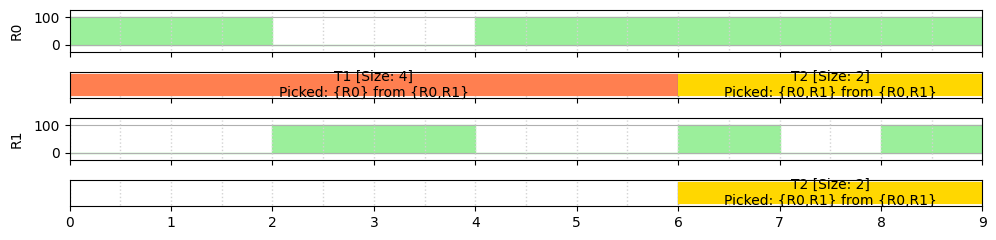

In [7]:
if sol and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (10, 2.5)
    task_colors = ['steelblue', 'coral', 'gold', 'mediumpurple', 'darkcyan', 'sandybrown']
    Task_Reqs_Map = {}
    for tid, size, reqs in TASKS:
        req_desc_list = []
        for qty, cands in reqs:
            cands_str = "{" + ",".join([f"R{c}" for c in cands]) + "}"
            req_desc_list.append(f"from {cands_str}")
        Task_Reqs_Map[tid] = " | ".join(req_desc_list)
    for r in range(M):
        visu.panel(f'R{r}')
        f_ind = CpoStepFunction()
        for t, v in RES_MAP[r]: 
            f_ind.set_value(t, 100000, v)
        visu.function(segments=f_ind, style='area', color='lightgreen')
        intervals_using_r = [itv for (tid, m_res), itv in Mode_Intervals.items() if r in m_res]
        for itv in intervals_using_r:
            sol_itv = sol.get_var_solution(itv)
            if sol_itv.is_present():
                name = itv.get_name()
                try:
                    tid_str = name.split('_')[0]
                    tid = int(tid_str[1:])
                    col = task_colors[tid % len(task_colors)]
                    size_val = sol_itv.get_size()
                    mode_part = name.split('_Mode_')[1]
                    clean_nums = mode_part.strip('()')
                    r_ids = [x.strip() for x in clean_nums.split(',') if x.strip()]
                    selected_team = "{" + ",".join([f"R{rid}" for rid in r_ids]) + "}"
                    
                    options = Task_Reqs_Map.get(tid, "None")
                    
                    label = (f"{tid_str} [Size: {size_val}]\n"
                             f"Picked: {selected_team} "
                             f"{options}")
                except Exception as e:
                    col = 'orange'
                    label = name
                visu.interval(sol_itv, col, label) 
    visu.show()